In [1]:
# Standard Packages
import pandas as pd
import pylab as plt
import numpy as np

# Spatial Handling
import geopandas as gpd
import shapely
import rasterio
import shapely.geometry
from shapely.geometry import LineString

import pandas as pd
import networkx as nx

## General Grid

Need to figure this one out later i guess

In [2]:
class PolygonGrid:
    def __init__(self, shapefile_path, grid_size=10, overlap=True, crs="EPSG:4326"):
        self.shapefile_path = shapefile_path
        self.grid_size = grid_size
        self.overlap = overlap
        self.crs = crs
        self.gdf = self.polygoninitialization()

    def polygoninitialization(self):
        # Load shapefile and filter for contiguous US states excluding Alaska (02) and Hawaii (15)
        gdf = gpd.read_file(self.shapefile_path)
        gdf = gdf.to_crs(epsg=4326)
        gdf = gdf[(pd.to_numeric(gdf['STATEFP']) < 60) & (pd.to_numeric(gdf['STATEFP']) != 2) & (pd.to_numeric(gdf['STATEFP']) != 15)]

        AZ = gdf[gdf['STATEFP'] == '04']
        AZ = AZ.drop(columns=['LSAD', 'ALAND', 'AWATER'])

        return AZ.reset_index(drop=True)

    def create_grid(self):
        """Create square grid that covers a geodataframe area
        or a fixed boundary with latitude-longitude coordinates
        returns: a GeoDataFrame of grid polygons
        """
        # Determine bounds
        lon_min, lat_min, lon_max, lat_max = self.gdf.total_bounds

        # Calculate cell size
        cell_size = (lon_max - lon_min) / self.grid_size

        # Create grid cells
        grid_cells = [
            shapely.geometry.box(lon0, lat0, lon0 + cell_size, lat0 + cell_size)
            for lon0 in np.arange(lon_min, lon_max + cell_size, cell_size)
            for lat0 in np.arange(lat_min, lat_max + cell_size, cell_size)
        ]

        cells = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=self.crs)
        cells['ID'] = range(1, len(cells) + 1)

        # Handle overlap
        if self.overlap:
            cells = cells.sjoin(self.gdf, how='inner').drop_duplicates('geometry')
            cells['ID'] = range(1, len(cells) + 1)

        return cells

# Usage
polygon_grid = PolygonGrid("cb_2023_us_county_500k.shp")
grid = polygon_grid.create_grid()
grid

,geometry,ID,index_right,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME
1,"POLYGON ((-114.23938 31.90931, -114.23938 32.4...",1,2,04,027,00023901,0500000US04027,04027,Yuma,Yuma County,AZ,Arizona
2,"POLYGON ((-114.23938 32.48643, -114.23938 33.0...",2,2,04,027,00023901,0500000US04027,04027,Yuma,Yuma County,AZ,Arizona
3,"POLYGON ((-114.23938 33.06356, -114.23938 33.6...",3,2,04,027,00023901,0500000US04027,04027,Yuma,Yuma County,AZ,Arizona
12,"POLYGON ((-113.66225 31.90931, -113.66225 32.4...",4,2,04,027,00023901,0500000US04027,04027,Yuma,Yuma County,AZ,Arizona
13,"POLYGON ((-113.66225 32.48643, -113.66225 33.0...",5,2,04,027,00023901,0500000US04027,04027,Yuma,Yuma County,AZ,Arizona
...,...,...,...,...,...,...,...,...,...,...,...,...
104,"POLYGON ((-109.04522 34.21782, -109.04522 34.7...",92,4,04,001,00025441,0500000US04001,04001,Apache,Apache County,AZ,Arizona
105,"POLYGON ((-109.04522 34.79495, -109.04522 35.3...",93,4,04,001,00025441,0500000US04001,04001,Apache,Apache County,AZ,Arizona
106,"POLYGON ((-109.04522 35.37208, -109.04522 35.9...",94,4,04,001,00025441,0500000US04001,04001,Apache,Apache County,AZ,Arizona
107,"POLYGON ((-109.04522 35.94921, -109.04522 36.5...",95,4,04,001,00025441,0500000US04001,04001,Apache,Apache County,AZ,Arizona


# Polygon for a U.S. State

In [3]:
class Polygon:
    @staticmethod
    def polygoninitialization(stateabrev):
        # Load shapefile and separate into specific state by STATEFP
        shapefile_path = "cb_2023_us_county_500k.shp"
        gdf = gpd.read_file(shapefile_path)
        gdf = gdf.to_crs(epsg=4326)
        gdf = gdf[(pd.to_numeric(gdf['STATEFP']) < 60) & (pd.to_numeric(gdf['STATEFP']) != 2) & (pd.to_numeric(gdf['STATEFP']) != 15)]
        gdf['STATEFP'] = gdf['STATEFP'].astype(int)
        
        STATE_NAMES = pd.read_csv('STATE_NAMES.csv') # imports the State_name, Abbreviation, and STATEFP (as id)
        STATE_NAMES['STATEFP'] = STATE_NAMES['STATEFP'].astype(int) # Convert to int for pointer 
        statefp_values = STATE_NAMES[STATE_NAMES['Abrev'].isin(stateabrev)]['STATEFP'].values # maps the input abbreviations to the corresponding STATEFP
        State = gdf[gdf['STATEFP'].isin(statefp_values)] # returns geopandas dataframe of statefps  

        State = State.drop(columns=['LSAD', 'ALAND', 'AWATER'])
        return State.reset_index(drop=True)

class Grid:
    @staticmethod
    def create_grid(df, grid_size):
        # GRID CREATION
        grid_creator = GridCreator(df, grid_size=grid_size)
        gr = grid_creator.create_grid()
        return gr

class GridCreator:
    def __init__(self, gdf=None, bounds=None, grid_size=None, overlap=True, crs="EPSG:4326"):
        self.gdf = gdf
        self.bounds = bounds
        self.grid_size = grid_size
        self.overlap = overlap
        self.crs = crs

    def get_county_mix(self, cell):
        intersecting_counties = self.gdf[self.gdf.intersects(cell['geometry'])]

        if len(intersecting_counties) == 0:
            return None

        total_area = intersecting_counties['geometry'].unary_union.area
        county_mix = {}

        # If total area is 0
        if total_area == 0:
            for county_id in intersecting_counties['GEOID']:
                county_mix[county_id] = 0
            return county_mix

        # If total area is nonzero
        for index, county in intersecting_counties.iterrows():
            intersection_area = cell['geometry'].intersection(county['geometry']).area
            proportion = 1 - intersection_area / total_area
            county_mix[county['GEOID']] = proportion

        return county_mix

    def create_grid(self):
        lon_min, lat_min, lon_max, lat_max = self.gdf.total_bounds
        cell_size = (lon_max - lon_min) / self.grid_size

        grid_cells = [
            shapely.geometry.box(lon0, lat0, lon0 + cell_size, lat0 + cell_size)
            for lon0 in np.arange(lon_min, lon_max, cell_size)
            for lat0 in np.arange(lat_min, lat_max, cell_size)
        ]

        cells = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=self.crs)
        cells['ID'] = range(1, len(cells) + 1)

        if self.overlap:
            cells = cells.sjoin(self.gdf, how='inner').drop_duplicates('geometry')
            cells['ID'] = range(1, len(cells) + 1)

        cells['County_Mix'] = cells.apply(self.get_county_mix, axis=1)

        return cells
    
class Adjacency_Polygon:
    @classmethod
    def calculate_adjacency_matrix(cls, grid):
        n = len(grid)
        adj_matrix = np.zeros((n, n), dtype=int)
        
        # Moore Neighborhood
        for i in range(n):
            for j in range(i + 1, n):
                if grid.iloc[i].geometry.touches(grid.iloc[j].geometry):
                    adj_matrix[i, j] = 1
                    adj_matrix[j, i] = 1

        adj_df = pd.DataFrame(adj_matrix, index=range(1, n+1), columns=range(1, n+1))
        return adj_df


# Usage
stateabrev = ['AZ']  # state abrev
grid_size = 50  # Define the grid size as 10x10
grid = Grid.create_grid(Polygon.polygoninitialization(stateabrev), grid_size)
#grid
# adj_matrix = Adjacency_Polygon.calculate_adjacency_matrix(grid)

In [4]:
shapefile_path = "cb_2023_us_county_500k.shp"
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs(epsg=4326)
gdf = gdf[(pd.to_numeric(gdf['STATEFP']) < 60) & (pd.to_numeric(gdf['STATEFP']) != 2) & (pd.to_numeric(gdf['STATEFP']) != 15)]
gdf['STATEFP'] = gdf['STATEFP'].astype(int)
        
STATE_NAMES = pd.read_csv('STATE_NAMES.csv') # imports the State_name, Abbreviation, and STATEFP (as id)
STATE_NAMES['STATEFP'] = STATE_NAMES['STATEFP'].astype(int) # Convert to int for pointer 
statefp_values = STATE_NAMES[STATE_NAMES['Abrev'].isin(stateabrev)]['STATEFP'].values # maps the input abbreviations to the corresponding STATEFP
State = gdf[gdf['STATEFP'].isin(statefp_values)] # returns geopandas dataframe of statefps  

State = State.drop(columns=['LSAD', 'ALAND', 'AWATER'])
State.reset_index(drop=True)
State

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,geometry
38,4,009,00025444,0500000US04009,04009,Graham,Graham County,AZ,Arizona,"POLYGON ((-110.45719 33.29527, -110.45299 33.2..."
323,4,005,00025443,0500000US04005,04005,Coconino,Coconino County,AZ,Arizona,"POLYGON ((-113.35413 36.04209, -113.35204 36.0..."
324,4,027,00023901,0500000US04027,04027,Yuma,Yuma County,AZ,Arizona,"POLYGON ((-114.81629 32.50804, -114.81432 32.5..."
325,4,012,00043540,0500000US04012,04012,La Paz,La Paz County,AZ,Arizona,"POLYGON ((-114.73122 33.30404, -114.72990 33.3..."
326,4,001,00025441,0500000US04001,04001,Apache,Apache County,AZ,Arizona,"POLYGON ((-110.00068 36.99798, -110.00068 36.9..."
396,4,013,00037026,0500000US04013,04013,Maricopa,Maricopa County,AZ,Arizona,"POLYGON ((-113.33505 33.55195, -113.33505 33.5..."
397,4,007,00040471,0500000US04007,04007,Gila,Gila County,AZ,Arizona,"POLYGON ((-111.72065 34.16270, -111.71977 34.1..."
398,4,021,00025447,0500000US04021,04021,Pinal,Pinal County,AZ,Arizona,"POLYGON ((-112.20361 32.53820, -112.20361 32.5..."
810,4,015,00025445,0500000US04015,04015,Mohave,Mohave County,AZ,Arizona,"POLYGON ((-114.75320 36.08951, -114.74953 36.0..."
826,4,025,00042809,0500000US04025,04025,Yavapai,Yavapai County,AZ,Arizona,"POLYGON ((-113.33394 34.67732, -113.33310 34.6..."


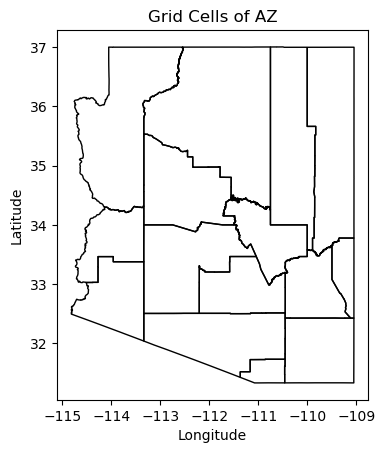

In [5]:
State.plot(fc="none", ec='black')
# Annotate each polygon with its ID
# for idx, row in grid.iterrows():
#     plt.annotate(text=str(row['ID']), xy=(row['geometry'].centroid.x, row['geometry'].centroid.y), color='red')
plt.title('Grid Cells of AZ')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('AZ_polygon.png')
plt.show()

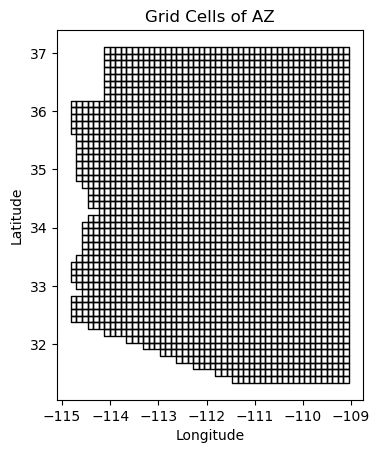

In [6]:
grid.plot(fc="none", ec='black')
# Annotate each polygon with its ID
# for idx, row in grid.iterrows():
#     plt.annotate(text=str(row['ID']), xy=(row['geometry'].centroid.x, row['geometry'].centroid.y), color='red')
plt.title('Grid Cells of AZ')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('AZ_grid.png')
plt.show()

# US States Adjacency

Note: In some instances the boundary between two counties may fall within a body of water, so it seems as if the two counties do not physically touch.  These counties are included on the list as neighbors. (https://www.census.gov/geographies/reference-files/2010/geo/county-adjacency.html)

In [7]:
class GeoDataFrameOperations:
    @staticmethod
    def create_tuples(df):
        '''
        Removes Duplicates and creates tuples
        '''
        all_tuples = list(df.itertuples(index=False, name=None))
        final_tuples = []
        for tuple in all_tuples:
            if (tuple[1], tuple[0]) not in final_tuples:
                if tuple[1] != tuple[0]:
                    final_tuples.append((str(tuple[0]), str(tuple[1])))
        return final_tuples

In [8]:
## lOAD POLYGON FILE
# Load shapefile and separate into Arizona
shapefile_path = "cb_2023_us_county_500k.shp"

# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(shapefile_path)

gdf = gdf.to_crs(epsg=4326) # convert the shapefile dataframe to ESPG:4326

gdf = gdf[(pd.to_numeric(gdf['STATEFP'])<60)&(pd.to_numeric(gdf['STATEFP'])!=2)&(pd.to_numeric(gdf['STATEFP'])!=15)]

pd.read_csv('Adjacency_Table.csv')

#grid_creator = GridCreator()

#AZ = gdf[gdf['STATEFP'] == '04' ]

,County Name,State Name,County GEOID,Neighbor County,Neighbor State,Neighbor GEOID
0,Autauga County,AL,1001,Autauga County,AL,1001
1,Autauga County,AL,1001,Chilton County,AL,1021
2,Autauga County,AL,1001,Dallas County,AL,1047
3,Autauga County,AL,1001,Elmore County,AL,1051
4,Autauga County,AL,1001,Lowndes County,AL,1085
...,...,...,...,...,...,...
22192,St. Croix Island,VI,78010,St. Croix Island,VI,78010
22193,St. John Island,VI,78020,St. John Island,VI,78020
22194,St. John Island,VI,78020,St. Thomas Island,VI,78030
22195,St. Thomas Island,VI,78030,St. John Island,VI,78020


C:\Users\sdc24\AppData\Local\Temp\ipykernel_7628\1619460241.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


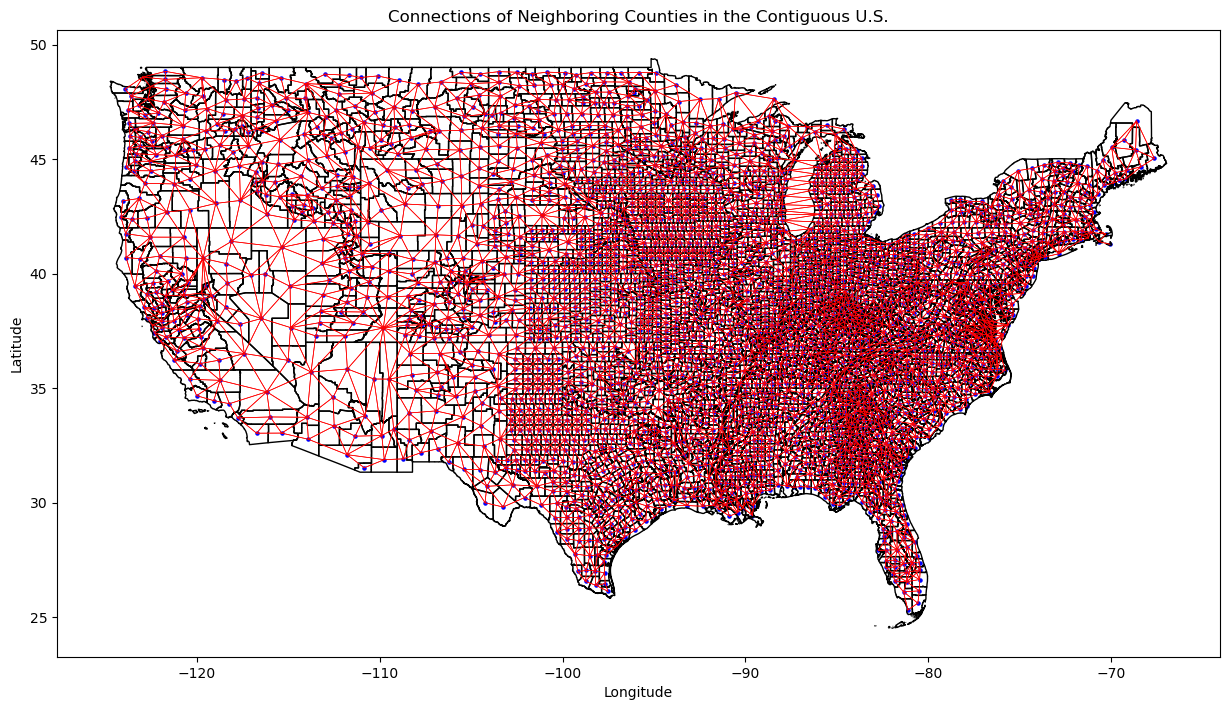

In [9]:
# Load the shapefile into a GeoDataFrame
shapefile_path = "cb_2023_us_county_500k.shp"

# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(shapefile_path)

gdf = gdf.to_crs(epsg=4326) # convert the shapefile dataframe to ESPG:4326

gdf = gdf[(pd.to_numeric(gdf['STATEFP'])<60)&(pd.to_numeric(gdf['STATEFP'])!=2)&(pd.to_numeric(gdf['STATEFP'])!=15)]

gdf['GEOID'] = gdf['GEOID'].astype(int).astype(str)
# Calculate the centroids of the counties
gdf['centroid'] = gdf.geometry.centroid

# Load the adjacency table
adjacency_df = pd.read_csv('Adjacency_Table.csv')

adjacency_df['County GEOID'] = adjacency_df['County GEOID'].astype(int).astype(str)
adjacency_df['Neighbor GEOID'] = adjacency_df['Neighbor GEOID'].astype(int).astype(str)

# Plot the counties and draw connections
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot the counties
gdf.boundary.plot(ax=ax, linewidth=1, color='black')

# Plot the centroids
gdf['centroid'].plot(ax=ax, color='blue', markersize=5)

# Draw lines between neighboring counties
for index, row in adjacency_df.iterrows():
    county1 = gdf[gdf['GEOID'] == str(row['County GEOID'])]
    county2 = gdf[gdf['GEOID'] == str(row['Neighbor GEOID'])]
    
    if not county1.empty and not county2.empty:
        county1_centroid = county1['centroid'].iloc[0]
        county2_centroid = county2['centroid'].iloc[0]
        ax.plot([county1_centroid.x, county2_centroid.x], 
                [county1_centroid.y, county2_centroid.y], 
                color='red', linewidth=0.5)

plt.title('Connections of Neighboring Counties in the Contiguous U.S.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.savefig('Counties_US.png', bbox_inches='tight')  # Adjust the path and file name as needed

plt.show()


In [23]:
shapefile_path = "cb_2023_us_county_500k.shp"
# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(shapefile_path)

gdf = gdf.to_crs(epsg=4326) # convert the shapefile dataframe to ESPG:4326

gdf = gdf[(pd.to_numeric(gdf['STATEFP'])<60)&(pd.to_numeric(gdf['STATEFP'])!=2)&(pd.to_numeric(gdf['STATEFP'])!=15)]

gdf['GEOID'] = gdf['GEOID'].astype(int).astype(str)
# Calculate the centroids of the counties
gdf['centroid'] = gdf.geometry.centroid
gdf[gdf['STUSPS'] == 'AZ']

C:\Users\sdc24\AppData\Local\Temp\ipykernel_28544\4076697956.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,centroid
38,04,009,00025444,0500000US04009,4009,Graham,Graham County,AZ,Arizona,06,11970605959,47476264,"POLYGON ((-110.45719 33.29527, -110.45299 33.2...",POINT (-109.88748 32.93260)
323,04,005,00025443,0500000US04005,4005,Coconino,Coconino County,AZ,Arizona,06,48216132682,116637123,"POLYGON ((-113.35413 36.04209, -113.35204 36.0...",POINT (-111.77052 35.83873)
324,04,027,00023901,0500000US04027,4027,Yuma,Yuma County,AZ,Arizona,06,14280726749,13242852,"POLYGON ((-114.81629 32.50804, -114.81432 32.5...",POINT (-113.90563 32.76948)
325,04,012,00043540,0500000US04012,4012,La Paz,La Paz County,AZ,Arizona,06,11646086556,36514346,"POLYGON ((-114.73122 33.30404, -114.72990 33.3...",POINT (-113.98149 33.72940)
326,04,001,00025441,0500000US04001,4001,Apache,Apache County,AZ,Arizona,06,29003497251,54139714,"POLYGON ((-110.00068 36.99798, -110.00068 36.9...",POINT (-109.48882 35.39552)
396,04,013,00037026,0500000US04013,4013,Maricopa,Maricopa County,AZ,Arizona,06,23833110838,62124435,"POLYGON ((-113.33505 33.55195, -113.33505 33.5...",POINT (-112.49146 33.34901)
397,04,007,00040471,0500000US04007,4007,Gila,Gila County,AZ,Arizona,06,12322068647,96466819,"POLYGON ((-111.72065 34.16270, -111.71977 34.1...",POINT (-110.81160 33.79971)
398,04,021,00025447,0500000US04021,4021,Pinal,Pinal County,AZ,Arizona,06,13899613086,20747212,"POLYGON ((-112.20361 32.53820, -112.20361 32.5...",POINT (-111.34476 32.90440)
810,04,015,00025445,0500000US04015,4015,Mohave,Mohave County,AZ,Arizona,06,34530024142,333399390,"POLYGON ((-114.75320 36.08951, -114.74953 36.0...",POINT (-113.75789 35.70408)
826,04,025,00042809,0500000US04025,4025,Yavapai,Yavapai County,AZ,Arizona,06,21038297493,11358280,"POLYGON ((-113.33394 34.67732, -113.33310 34.6...",POINT (-112.55374 34.59982)


C:\Users\sdc24\AppData\Local\Temp\ipykernel_7628\1019091537.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


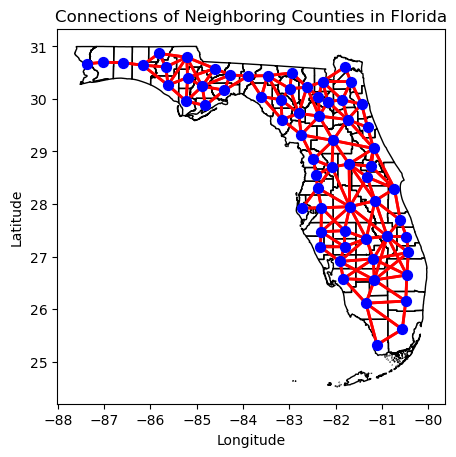

In [16]:
shapefile_path = "cb_2023_us_county_500k.shp"
# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(shapefile_path)

gdf = gdf.to_crs(epsg=4326) # convert the shapefile dataframe to ESPG:4326

gdf = gdf[(pd.to_numeric(gdf['STATEFP'])<60)&(pd.to_numeric(gdf['STATEFP'])!=2)&(pd.to_numeric(gdf['STATEFP'])!=15)]

gdf['GEOID'] = gdf['GEOID'].astype(int).astype(str)
# Calculate the centroids of the counties
gdf['centroid'] = gdf.geometry.centroid
gdf = gdf[gdf['STUSPS'] == 'FL']

# Load the adjacency table
adjacency_df = pd.read_csv('Adjacency_Table.csv')

adjacency_df = adjacency_df[adjacency_df['State Name'] == ' FL']

adjacency_df['County GEOID'] = adjacency_df['County GEOID'].astype(int).astype(str)
adjacency_df['Neighbor GEOID'] = adjacency_df['Neighbor GEOID'].astype(int).astype(str)

# Plot the counties and draw connections
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot the counties
gdf.boundary.plot(ax=ax, linewidth=1, color='black')


# Draw lines between neighboring counties
for index, row in adjacency_df.iterrows():
    county1 = gdf[gdf['GEOID'] == str(row['County GEOID'])]
    county2 = gdf[gdf['GEOID'] == str(row['Neighbor GEOID'])]
    
    if not county1.empty and not county2.empty:
        county1_centroid = county1['centroid'].iloc[0]
        county2_centroid = county2['centroid'].iloc[0]
        ax.plot([county1_centroid.x, county2_centroid.x], 
                [county1_centroid.y, county2_centroid.y], 
                color='red', linewidth=2)

        
# Plot the centroids
gdf['centroid'].plot(ax=ax, color='blue', markersize=50, zorder=3)
plt.title('Connections of Neighboring Counties in Florida')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.savefig('FL_Adj.png', bbox_inches='tight')  # Adjust the path and file name as needed

plt.show()


In [21]:
# Filter the DataFrame for rows where 'State Name' is 'MN'
filtered_df = adjacency_df[adjacency_df['State Name'] == ' WI']

# Further filter the DataFrame for rows where 'Neighbor State' is 'MI'
mi_neighbors = filtered_df[filtered_df['Neighbor State'] == ' MI']

mi_neighbors


,County Name,State Name,County GEOID,Neighbor County,Neighbor State,Neighbor GEOID
21047,Ashland County,WI,55003,Gogebic County,MI,26053
21048,Ashland County,WI,55003,Ontonagon County,MI,26131
21143,Door County,WI,55029,Benzie County,MI,26019
21144,Door County,WI,55029,Delta County,MI,26041
21145,Door County,WI,55029,Leelanau County,MI,26089
21146,Door County,WI,55029,Menominee County,MI,26109
21177,Florence County,WI,55037,Dickinson County,MI,26043
21178,Florence County,WI,55037,Iron County,MI,26071
21189,Forest County,WI,55041,Iron County,MI,26071
21226,Iron County,WI,55051,Gogebic County,MI,26053


In [12]:
len(adj_df['County GEOID'].unique())

3235

In [9]:
GEOID_tuples = GeoDataFrameOperations.create_tuples(adj_df[['County GEOID', 'Neighbor GEOID']]) # create tuples of county and neighboring counties to add to network graph

G = nx.Graph() # initialize graph
G.add_edges_from(GEOID_tuples) # Add the edges 

adj_matrix = nx.to_pandas_adjacency(G)
adj_matrix

,1001,1021,1047,1051,1085,1101,1003,1025,1053,1097,...,72051,72055,72121,72069,72151,72093,72145,72095,78020,78030
1001,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1021,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1047,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1051,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1085,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
78020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
class CountyAdjacencyMatrix:
    @staticmethod
    def C_generate_adjacency_matrix():
        # Generate adjacency graph and matrix
        adjacency = pd.read_csv('Adjacency_Table.csv')
        adj_df = adjacency.copy()

        GEOID_tuples = GeoDataFrameOperations.create_tuples(adj_df[['County GEOID', 'Neighbor GEOID']]) # create tuples of county and neighboring counties to add to network graph

        G = nx.Graph() # initialize graph
        G.add_edges_from(GEOID_tuples) # Add the edges 

        adj_matrix = nx.to_pandas_adjacency(G)
        return adj_matrix

In [9]:
adj_matrix = CountyAdjacencyMatrix.C_generate_adjacency_matrix()
number_of_patches = len(adj_matrix.values[0])
    
adjacency_matrix = adj_matrix.values

In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd

class SIRModelSBML:
    def __init__(self):
        # Create the root element for the SBML document
        self.root = ET.Element("{http://www.sbml.org/sbml/level3/version1/core}sbml", level="3", version="1")
        self.model = ET.SubElement(self.root, "model", id="Model_generated_by_BIOCHAM")
        self.list_of_compartments = ET.SubElement(self.model, "listOfCompartments")
        self.list_of_species = ET.SubElement(self.model, "listOfSpecies")
        self.list_of_parameters = ET.SubElement(self.model, "listOfParameters")
        self.list_of_initial_assignments = ET.SubElement(self.model, "listOfInitialAssignments")
        self.list_of_reactions = ET.SubElement(self.model, "listOfReactions")

    def add_compartment(self, compartment_id, spatial_dimensions="3", size="1", constant="true"):
        # Add compartment to the model
        ET.SubElement(self.list_of_compartments, "compartment", id=compartment_id,
                      spatialDimensions=spatial_dimensions, size=size, constant=constant)

    def add_species(self, species_id, name, compartment, initial_concentration="0", has_only_substance_units="false",
                    boundary_condition="false", constant="false"):
        # Create species
        ET.SubElement(self.list_of_species, "species", id=species_id, name=name, compartment=compartment,
                      initialConcentration=initial_concentration, hasOnlySubstanceUnits=has_only_substance_units,
                      boundaryCondition=boundary_condition, constant=constant)

    def add_parameter(self, parameter_id, name, value, constant="true"):
        # Create parameter
        ET.SubElement(self.list_of_parameters, "parameter", id=parameter_id, name=name, value=value, constant=constant)

    def add_initial_assignment(self, symbol, math_content):
        # Create initial assignment
        initial_assignment = ET.SubElement(self.list_of_initial_assignments, "initialAssignment", symbol=symbol)
        math = ET.SubElement(initial_assignment, "math", xmlns="http://www.w3.org/1998/Math/MathML")
        math.append(ET.fromstring(math_content))  # Parse MathML from string and append

    def add_reaction(self, reaction_id, reversible="false", reactants=None, products=None, kinetic_law_math=None):
        # Create reaction
        reaction = ET.SubElement(self.list_of_reactions, "reaction", id=reaction_id, reversible=reversible, fast="false")

        # Add reactants
        if reactants:
            list_of_reactants = ET.SubElement(reaction, "listOfReactants")
            for species_id, stoichiometry in reactants.items():
                ET.SubElement(list_of_reactants, "speciesReference", species=species_id, stoichiometry=str(stoichiometry), constant="true")

        # Add products
        if products:
            list_of_products = ET.SubElement(reaction, "listOfProducts")
            for species_id, stoichiometry in products.items():
                ET.SubElement(list_of_products, "speciesReference", species=species_id, stoichiometry=str(stoichiometry), constant="true")

        # Create kinetic law with MathML
        kinetic_law = ET.SubElement(reaction, "kineticLaw")
        math = ET.SubElement(kinetic_law, "math", xmlns="http://www.w3.org/1998/Math/MathML")
        math.append(ET.fromstring(kinetic_law_math))  # Parse MathML from string and append
        

def create_model(model_type):
    
    adj_matrix = AdjacencyMatrixGenerator.generate_adjacency_matrix()
    number_of_patches = len(adj_matrix.values[0])
    
    adjacency_matrix = adj_matrix.values
    
    if model_type == "SIR":
        sir_model = SIRModelSBML()

        for patch_num in range(1, number_of_patches + 1): # we want to start at 1 for labeling purposes due to SBML had difficulty with starting at 0 and input data
            #patch_num = adj_matrix.columns[patch_num-1] # Error for np.where(adjacency_matrix[patch_num - 1] == 1
            compartment_id = f"compartment{patch_num}"
            sir_model.add_compartment(compartment_id, spatial_dimensions="3", size="1", constant="true")

            for species_type in ["S", "I", "R"]:
                species_id = f"{species_type}{patch_num}"
                sir_model.add_species(species_id, name=species_id, compartment=compartment_id, initial_concentration="10")

            for param_name in ["beta", "gamma", "delta", "I0", "R0", "S0"]:
                param_id = f"{param_name}"
                param_value = "0.3" if param_name == "beta" else "0.1" if param_name == "gamma" else "0.01"  if param_name == "delta" else "0.01"if param_name == "I0" else "0" if param_name == "R0" else "0.99"
                sir_model.add_parameter(param_id, name=param_name, value=param_value, constant="true")

            for state_var in ["S", "I", "R"]:
                initial_assignment_symbol = f"{state_var}{patch_num}"
                sir_model.add_initial_assignment(initial_assignment_symbol, f"<ci>{state_var}0</ci>")
                
            # reactions and kinetic laws WITHIN the patch
            kinetic_law_reaction_1 = f"<apply><times/><ci>gamma</ci><ci>I{patch_num}</ci></apply>"
            kinetic_law_reaction_2 = f"<apply><times/><ci>beta</ci><ci>S{patch_num}</ci><ci>I{patch_num}</ci></apply>"

            sir_model.add_reaction(f"R_{patch_num}_I", reactants={f"I{patch_num}": 1}, products={f"R{patch_num}": 1}, kinetic_law_math=kinetic_law_reaction_1)
            sir_model.add_reaction(f"R_{patch_num}_R", reactants={f"S{patch_num}": 1, f"I{patch_num}": 1}, products={f"I{patch_num}": 2}, kinetic_law_math=kinetic_law_reaction_2)
            
            # reactions and kinetic laws BETWEEN patches
            for neighbor_patch in np.where(adjacency_matrix[patch_num - 1] == 1)[0] + 1:
                #kinetic_law_reaction_between_patches = f"<apply><times/><ci>beta</ci><ci>delta{neighbor_patch}</ci><ci>S{patch_num}</ci></apply>" # Migration parameter based on patch number. Will use this later. Need to figure out how to dynamically add parameter value
                kinetic_law_reaction_between_patches_Susceptibles = f"<apply><times/><ci>beta</ci><ci>delta</ci><ci>S{patch_num}</ci></apply>"
                kinetic_law_reaction_between_patches_Infected = f"<apply><times/><ci>beta</ci><ci>delta</ci><ci>I{patch_num}</ci></apply>"
                sir_model.add_reaction(f"R_{patch_num}_{neighbor_patch}_I", reactants={f"I{patch_num}": 1}, products={f"I{neighbor_patch}": 1}, kinetic_law_math=kinetic_law_reaction_between_patches_Infected)
                sir_model.add_reaction(f"R_{patch_num}_{neighbor_patch}", reactants={f"S{patch_num}": 1}, products={f"S{neighbor_patch}": 1}, kinetic_law_math=kinetic_law_reaction_between_patches_Susceptibles)

        tree = ET.ElementTree(sir_model.root)
        tree.write("SIR_EXAMPLE_MOC_Multi.xml", encoding="UTF-8", xml_declaration=True, method="xml")


    elif model_type == "SEIR":
        sir_model = SIRModelSBML()

        for patch_num in range(1, number_of_patches + 1):
            compartment_id = f"compartment{patch_num}"
            sir_model.add_compartment(compartment_id, spatial_dimensions="3", size="1", constant="true")

            for species_type in ["S", "E", "I", "R"]: # added the Exposed 
                species_id = f"{species_type}{patch_num}"
                sir_model.add_species(species_id, name=species_id, compartment=compartment_id, initial_concentration="10")

            for param_name in ["beta", "gamma", "nu", "delta", "I0", "E0", "R0", "S0"]:
                param_id = f"{param_name}"
                param_value = "0.3" if param_name == "beta" else "0.1" if param_name == "nu" else "0.1" if param_name == "gamma" else "0.01"  if param_name == "delta" else "0.01"if param_name == "I0" else "0" if param_name == "R0" else "0.99"
                sir_model.add_parameter(param_id, name = param_name, value=param_value, constant="true")

            for state_var in ["S", "E", "I", "R"]:
                initial_assignment_symbol = f"{state_var}{patch_num}"
                sir_model.add_initial_assignment(initial_assignment_symbol, f"<ci>{state_var}0</ci>")

            kinetic_law_reaction_1 = f"<apply><times/><ci>gamma</ci><ci>I{patch_num}</ci></apply>"
            kinetic_law_reaction_2 = f"<apply><times/><ci>beta</ci><ci>S{patch_num}</ci><ci>I{patch_num}</ci></apply>"
            kinetic_law_reaction_3 = f"<apply><times/><ci>nu</ci><ci>E{patch_num}</ci></apply>"
    
            sir_model.add_reaction(f"R_{patch_num}_1", reactants={f"I{patch_num}": 1}, products={f"R{patch_num}": 1}, kinetic_law_math=kinetic_law_reaction_1)
            sir_model.add_reaction(f"R_{patch_num}_2", reactants={f"S{patch_num}": 1, f"I{patch_num}": 1}, products={f"I{patch_num}": 1, f"E{patch_num}": 1}, kinetic_law_math=kinetic_law_reaction_2)
            sir_model.add_reaction(f"I_{patch_num}_3", reactants={f"E{patch_num}": 1}, products={f"I{patch_num}": 1}, kinetic_law_math=kinetic_law_reaction_3)
            
            # reactions and kinetic laws BETWEEN patches
            for neighbor_patch in np.where(adjacency_matrix[patch_num - 1] == 1)[0] + 1:
                #kinetic_law_reaction_between_patches = f"<apply><times/><ci>beta</ci><ci>delta{neighbor_patch}</ci><ci>S{patch_num}</ci></apply>" # Migration parameter based on patch number. Will use this later. Need to figure out how to dynamically add parameter value
                kinetic_law_reaction_between_patches_Susceptibles = f"<apply><times/><ci>beta</ci><ci>delta</ci><ci>S{patch_num}</ci></apply>"
                kinetic_law_reaction_between_patches_Infected = f"<apply><times/><ci>beta</ci><ci>delta</ci><ci>I{patch_num}</ci></apply>"
                sir_model.add_reaction(f"R_{patch_num}_{neighbor_patch}_I", reactants={f"I{patch_num}": 1}, products={f"I{neighbor_patch}": 1}, kinetic_law_math=kinetic_law_reaction_between_patches_Infected)
                sir_model.add_reaction(f"R_{patch_num}_{neighbor_patch}", reactants={f"S{patch_num}": 1}, products={f"S{neighbor_patch}": 1}, kinetic_law_math=kinetic_law_reaction_between_patches_Susceptibles)


        tree = ET.ElementTree(sir_model.root)
        tree.write("SEIR_EXAMPLE_MOC_Multi.xml", encoding="UTF-8", xml_declaration=True, method="xml")
    else:
        print("Invalid model type. Supported types: 'SIR', 'SEIR'")


create_model(model_type="SIR")